In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont,Posterior_SF_spec
from spec_exam import Gen_spec, Calibrate_grism
from sim_engine import *
from spec_stats import Highest_density_region
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared
from C_sim_test import Gen_sim, F_lam_per_M
from spec_id import convert_sfh, get_agebins

import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
SF_db_p2 = pd.read_pickle('../Casey_data/SF_db_p2.pkl')

In [3]:

class Gen_SF_spec(object):
    def __init__(self, field, galaxy_id, specz,
                 g102_lims=[8200, 11300], g141_lims=[11200, 16000],
                phot_errterm = 0, irac_err = None, mask = True):
        self.field = field
        self.galaxy_id = galaxy_id
        self.specz = specz
        self.c = 3E18          # speed of light angstrom s^-1
        self.g102_lims = g102_lims
        self.g141_lims = g141_lims
        self.g102_beam = glob(cbeam_path + '*{0}*g102*'.format(galaxy_id))
        self.g141_beam = glob(cbeam_path + '*{0}*g141*'.format(galaxy_id))
        self.sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau = 0.1, dust_type = 1)
        self.mask = mask
        
        if len(self.g102_beam) < 1 :
            self.g102_beam = glob(cbeam_path + '*{0}*g102*'.format(10639))
        if len(self.g141_beam) < 1 :
            self.g141_beam = glob(cbeam_path + '*{0}*g141*'.format(10639))
        
        """
        B - prefix refers to g102
        R - prefix refers to g141
        P - prefix refers to photometry
        
        field - GND/GSD/UDS
        galaxy_id - ID number from 3D-HST
        specz - z_grism
        g102_lims - window for g102
        g141_lims - window for g141
        """
         
        ##load spec and phot
        try:
            self.Bwv, self.Bwv_rf, self.Bflx, self.Berr, self.Bflt, self.IDB, self.Bline, self.Bcont = load_spec_SF(self.field,
                                self.galaxy_id, 'g102', self.g102_lims,  self.specz, mask = self.mask)
            
            self.Bfl = self.Bflx / self.Bflt 
            self.Bbeam, self.Btrans = load_beams_and_trns(self.Bwv, self.g102_beam)
            self.Ber = self.Berr / self.Bflt
            self.g102 = True
            if self.mask == False:
                self.Bmask = get_mask(self.field, self.galaxy_id, self.Bwv, 'g102')
                
        except:
            print('missing g102')
            self.g102 = False
        
        try:
            self.Rwv, self.Rwv_rf, self.Rflx, self.Rerr, self.Rflt, self.IDR, self.Rline, self.Rcont = load_spec_SF(self.field,
                                self.galaxy_id, 'g141', self.g141_lims,  self.specz, mask = self.mask)

            self.Rfl = self.Rflx / self.Rflt 
            self.Rbeam, self.Rtrans = load_beams_and_trns(self.Rwv, self.g141_beam)
            self.Rer = self.Rerr / self.Rflt
            self.g141 = True
            if self.mask == False:
                self.Rmask = get_mask(self.field, self.galaxy_id, self.Rwv, 'g141')

        except:
            print('missing g141')
            self.g141 = False
        
        self.Pwv, self.Pwv_rf, self.Pflx, self.Perr, self.Pnum = load_spec_SF(self.field,
                                self.galaxy_id, 'phot', self.g141_lims,  self.specz, grism = False)
         
        self.Perr = apply_phot_err(self.Pflx, self.Perr, self.Pnum, base_err = phot_errterm, irac_err = irac_err)
        # load photmetry precalculated values
        self.model_photDF, self.IDP, self.sens_wv, self.trans, self.b, self.dnu, self.adj, self.mdleffwv = load_phot_precalc(self.Pnum)
    
    def Sim_spec_premade(self, model_wave, model_flux):
        if self.g102:
            self.Bmfl = self.Forward_model_all_beams_flatted(self.Bbeam, self.Btrans, self.Bwv, model_wave, model_flux)
            self.Bmfl *= self.PC

            if not self.set_scale:
                Bscale = Scale_model(self.Bfl, self.Ber, self.Bmfl)

                self.Bfl = self.Bfl / Bscale ; self.Ber = self.Ber / Bscale 
                
        if self.g141: 
            self.Rmfl = self.Forward_model_all_beams_flatted(self.Rbeam, self.Rtrans, self.Rwv, model_wave, model_flux) 
            self.Rmfl *= self.PC

            if not self.set_scale:
                Rscale = Scale_model(self.Rfl, self.Rer, self.Rmfl)

                self.Rfl = self.Rfl / Rscale ; self.Rer = self.Rer / Rscale 
    
    def Sim_phot_mult(self, model_wave, model_flux):
        return forward_model_phot(model_wave, model_flux, self.IDP, self.sens_wv, self.b, self.dnu, self.adj)

    def Sim_phot_premade(self, model_wave, model_flux, scale = True):
        self.Pmfl = self.Sim_phot_mult(model_wave, model_flux)
        self.PC =  Scale_model(self.Pflx, self.Perr, self.Pmfl)
        
        if scale == False:
            self.PC = 1
            
        self.Pmfl = self.Pmfl * self.PC
    
    @staticmethod
    def Forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
        return forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux)
    
    def Sim_all_premade(self, model_wave, model_flux, scale = True):
        self.Sim_phot_premade(model_wave, model_flux, scale = scale)
        self.Sim_spec_premade(model_wave, model_flux)
        
    def Best_fit_scale(self, model_wave, model_flux, specz, bp1, rp1, massperc,logmass):
        self.Full_forward_model(model_wave, F_lam_per_M(model_flux, model_wave * (1 + specz),
                            specz, 0, massperc)*10**logmass, specz)

        if self.g102:
            self.bcal = Calibrate_grism([self.Bwv, self.Bfl, self.Ber], self.Bmfl, bp1)
            if self.mask == False:
                self.bscale = Scale_model(self.Bfl[self.Bmask] / self.bcal[self.Bmask], 
                                          self.Ber[self.Bmask]/ self.bcal[self.Bmask], self.Bmfl[self.Bmask])

            else:
                self.bscale = Scale_model(self.Bfl / self.bcal, self.Ber/ self.bcal, self.Bmfl)
            self.Bfl =  self.Bfl/ self.bcal/ self.bscale
            self.Ber =  self.Ber/ self.bcal/ self.bscale
            
        if self.g141:
            self.rcal = Calibrate_grism([self.Rwv, self.Rfl, self.Rer], self.Rmfl, rp1)
            if self.mask == False:
                self.rscale = Scale_model(self.Rfl[self.Rmask] / self.rcal[self.Rmask], 
                                          self.Rer[self.Rmask]/ self.rcal[self.Rmask], self.Rmfl[self.Rmask])
                
            else:
                self.rscale = Scale_model(self.Rfl / self.rcal, self.Rer/ self.rcal, self.Rmfl)
            self.Rfl =  self.Rfl/ self.rcal/ self.rscale
            self.Rer =  self.Rer/ self.rcal/ self.rscale
            
    def Full_forward_model(self, model_wave, model_flux, specz):
        
        if self.g102:
            self.Bmfl = self.Forward_model_all_beams(self.Bbeam , self.Btrans, self.Bwv, model_wave * (1 + specz), model_flux)

        if self.g141:
            self.Rmfl = self.Forward_model_all_beams(self.Rbeam , self.Rtrans, self.Rwv, model_wave * (1 + specz), model_flux)
            
        self.Pmfl = self.Sim_phot_mult(model_wave * (1 + specz), model_flux)
        
    def Best_fit_scale_flam(self, model_wave, model_flam, specz, bp1, rp1):
        self.Full_forward_model(model_wave, model_flam, specz)

        if self.g102:
            self.bcal = Calibrate_grism([self.Bwv, self.Bfl, self.Ber], self.Bmfl, bp1)
            if self.mask == False:
                self.bscale = Scale_model(self.Bfl[self.Bmask] / self.bcal[self.Bmask], 
                                          self.Ber[self.Bmask]/ self.bcal[self.Bmask], self.Bmfl[self.Bmask])

            else:
                self.bscale = Scale_model(self.Bfl / self.bcal, self.Ber/ self.bcal, self.Bmfl)            
            self.Bfl =  self.Bfl/ self.bcal/ self.bscale
            self.Ber =  self.Ber/ self.bcal/ self.bscale
            
            
        if self.g141:
            self.rcal = Calibrate_grism([self.Rwv, self.Rfl, self.Rer], self.Rmfl, rp1)
            if self.mask == False:
                self.rscale = Scale_model(self.Rfl[self.Rmask] / self.rcal[self.Rmask], 
                                          self.Rer[self.Rmask]/ self.rcal[self.Rmask], self.Rmfl[self.Rmask])
                
            else:
                self.rscale = Scale_model(self.Rfl / self.rcal, self.Rer/ self.rcal, self.Rmfl)
            self.Rfl =  self.Rfl/ self.rcal/ self.rscale
            self.Rer =  self.Rer/ self.rcal/ self.rscale
            
    def Make_sim(self, model_wave, model_flux, specz, rndstate = 10, perturb = True):       
        self.SBfl, self.SBer,  self.SRfl, self.SRer, self.SPflx, self.SPerr =  init_sim(model_wave, 
        model_flux, specz, self.Bwv, self.Rwv, 
        self.Bfl, self.Rfl, self.Pflx, self.Ber, self.Rer, self.Perr, 0, 
        self.Btrans, self.Rtrans, self.Bbeam, self.Rbeam, 
        self.IDP, self.sens_wv, self.b, self.dnu, self.adj , rndstate = rndstate, perturb = perturb)

In [10]:
SF_db_p2[['field','id']]

,field,id
0,GND,35075
1,GND,35204
2,GND,28379
3,GND,32719
4,GND,30204
5,GND,20801
6,GND,11839
7,GND,17927
8,GND,17324
9,GND,13777


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


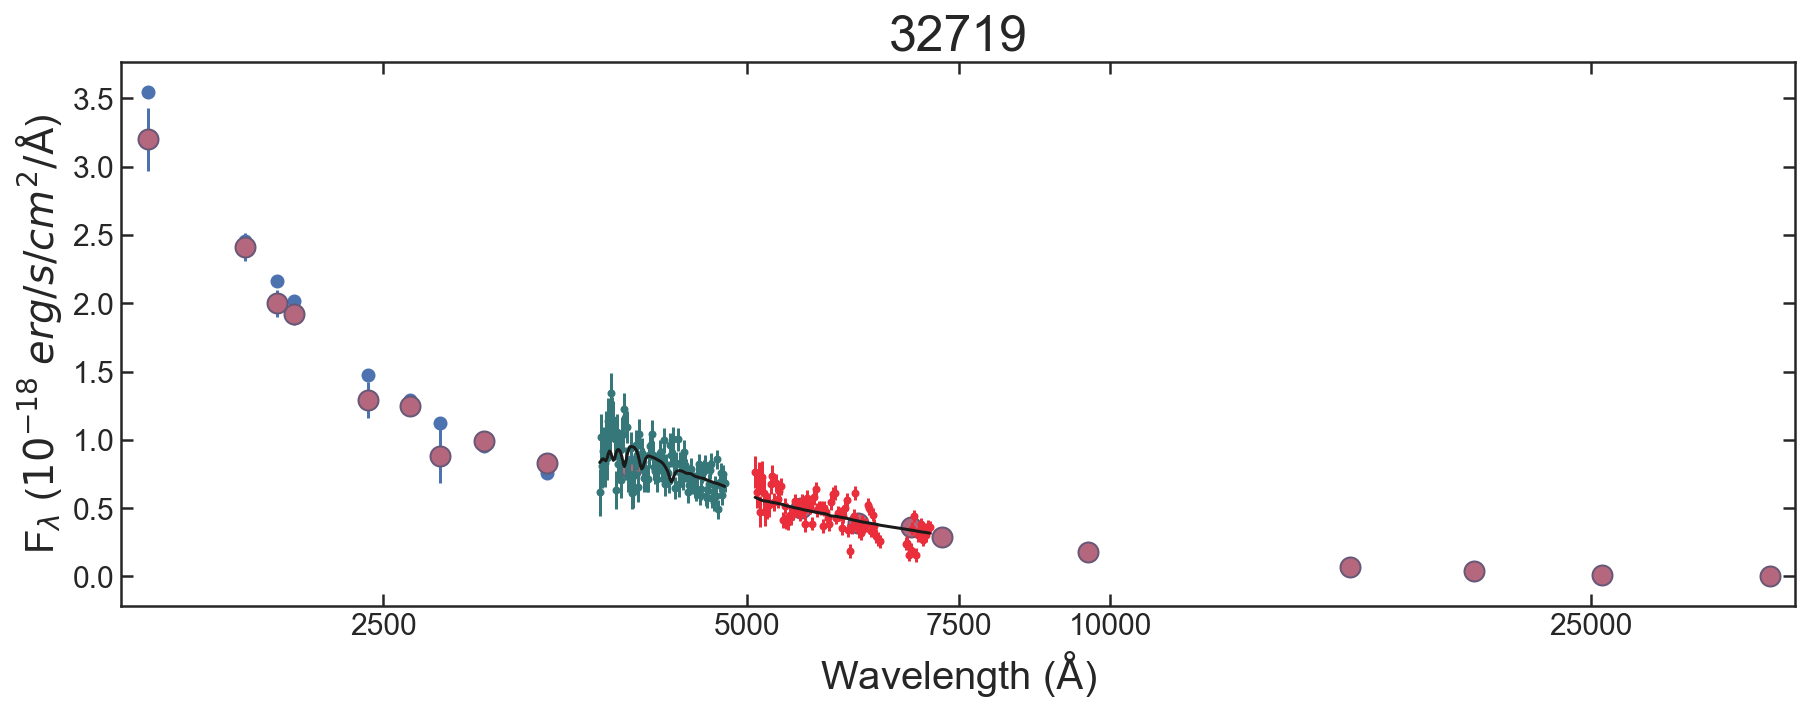

In [4]:
field = 'GND'
galaxy = 32719

grow = SF_db_p2.query('id == {0}'.format(galaxy))

Gs = Gen_SF_spec(field, galaxy, grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08, mask = True) 
Flam = Posterior_SF_spec(field, galaxy, grow.zgrism.values[0])

x,px = np.load('../Casey_data/posteriors/{0}_{1}_SFfit_p2_Pbp1.npy'.format(field, galaxy))
bp1 = x[px == max(px)][0]
x,px = np.load('../Casey_data/posteriors/{0}_{1}_SFfit_p2_Prp1.npy'.format(field, galaxy))
rp1 = x[px == max(px)][0]

Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

plt.figure(figsize=[15,5])
###############plot tab##################

if Gs.g102:
    plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
            linestyle='None', marker='o', markersize=3, color='#36787A', zorder = 2)
    plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4)
else:
    pass

if Gs.g141:
    plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
            linestyle='None', marker='o', markersize=3, color='#EA2E3B', zorder = 2)
    plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4)
else:
    pass

plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=10, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)
plt.scatter(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18)
plt.xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))

plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
plt.title(galaxy, fontsize=25)
plt.xlabel(r'Wavelength ($\rm  \AA$)', fontsize=20)
plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)


In [23]:
SF_db_p2.m1[3]

0.0396813813438505

In [20]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust1'] = 0

sp.params['dust2'] = SF_db_p2.Av[3]
# sp.params['logzsol'] = np.log10(SF_db_p2.Z[3])
sp.params['logzsol'] = np.log10(.1)

x,px = np.load('../Casey_data/posteriors/{0}_{1}_SFfit_p2_Pa.npy'.format(field, galaxy))
a = x[px == max(px)][0]

time, sfr, tmax = convert_sfh(get_agebins(a, binnum = 6), 
    [SF_db_p2.m1[3], SF_db_p2.m2[3], SF_db_p2.m3[3], SF_db_p2.m4[3], SF_db_p2.m5[3], SF_db_p2.m6[3]], maxage = a*1E9)

sp.set_tabular_sfh(time,sfr) 

In [21]:
wv,fl = sp.get_spectrum(tage=a,peraa=True)

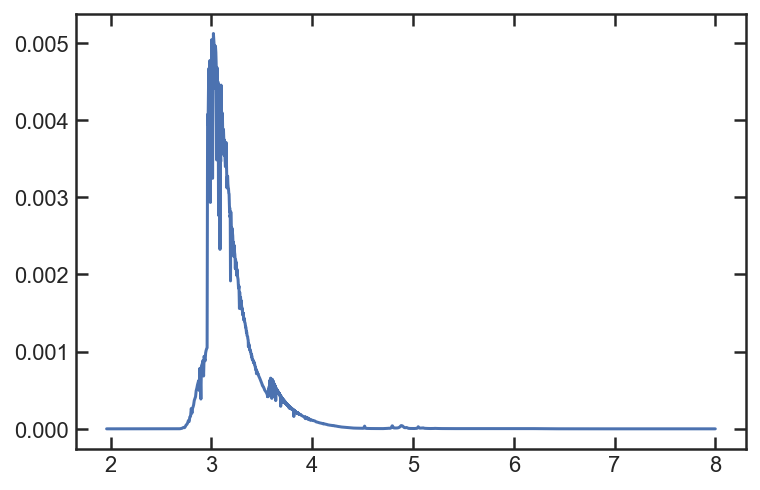

In [22]:
plt.plot(np.log10(wv),fl)

In [23]:
wv,fl = sp.get_spectrum(tage=a,peraa=True)
Gs.Make_sim(wv,fl,SF_db_p2.zgrism[3])


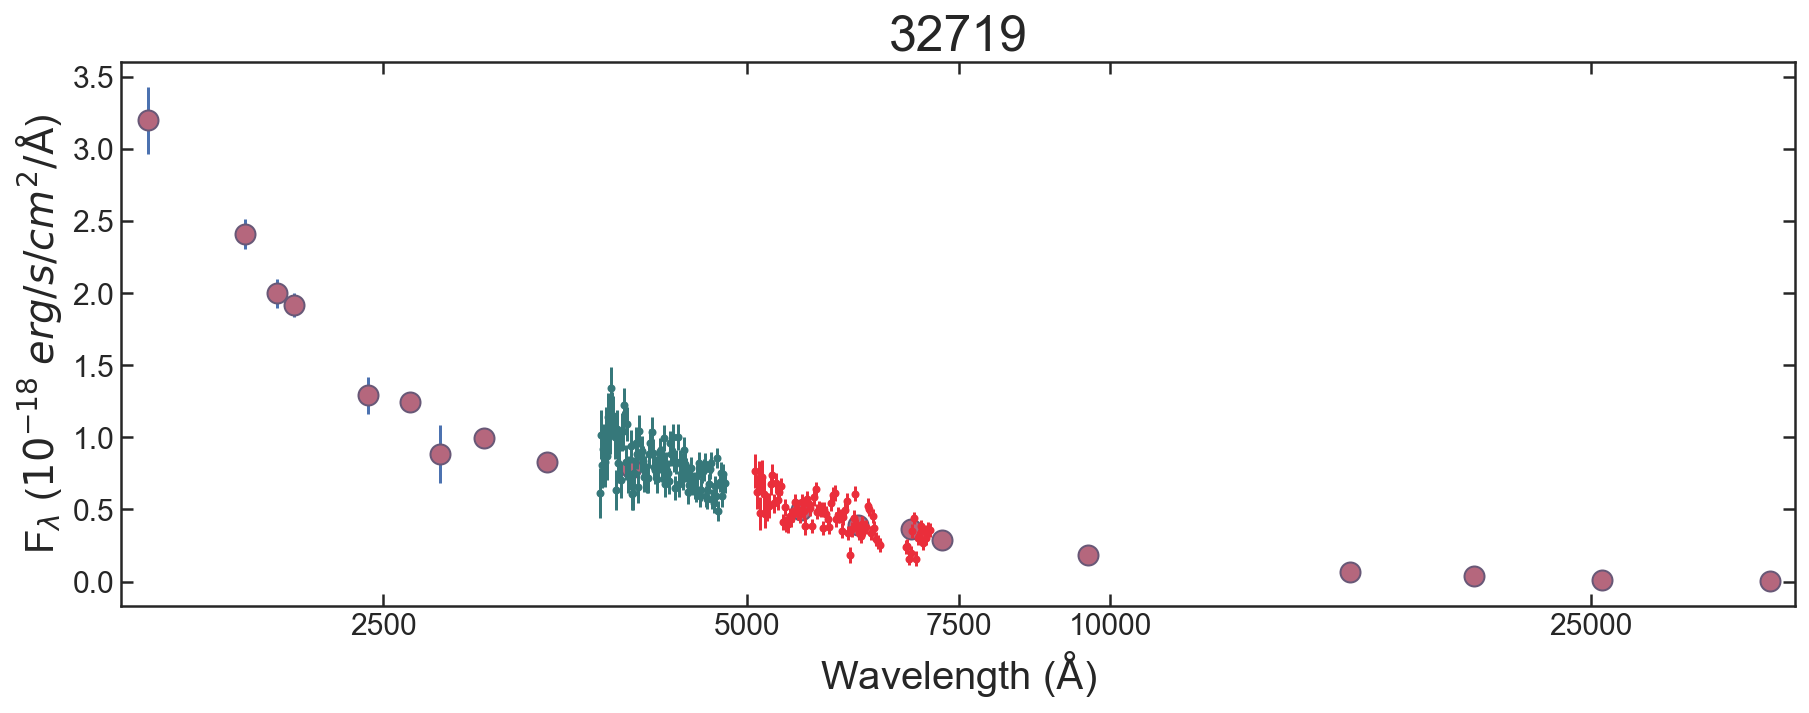

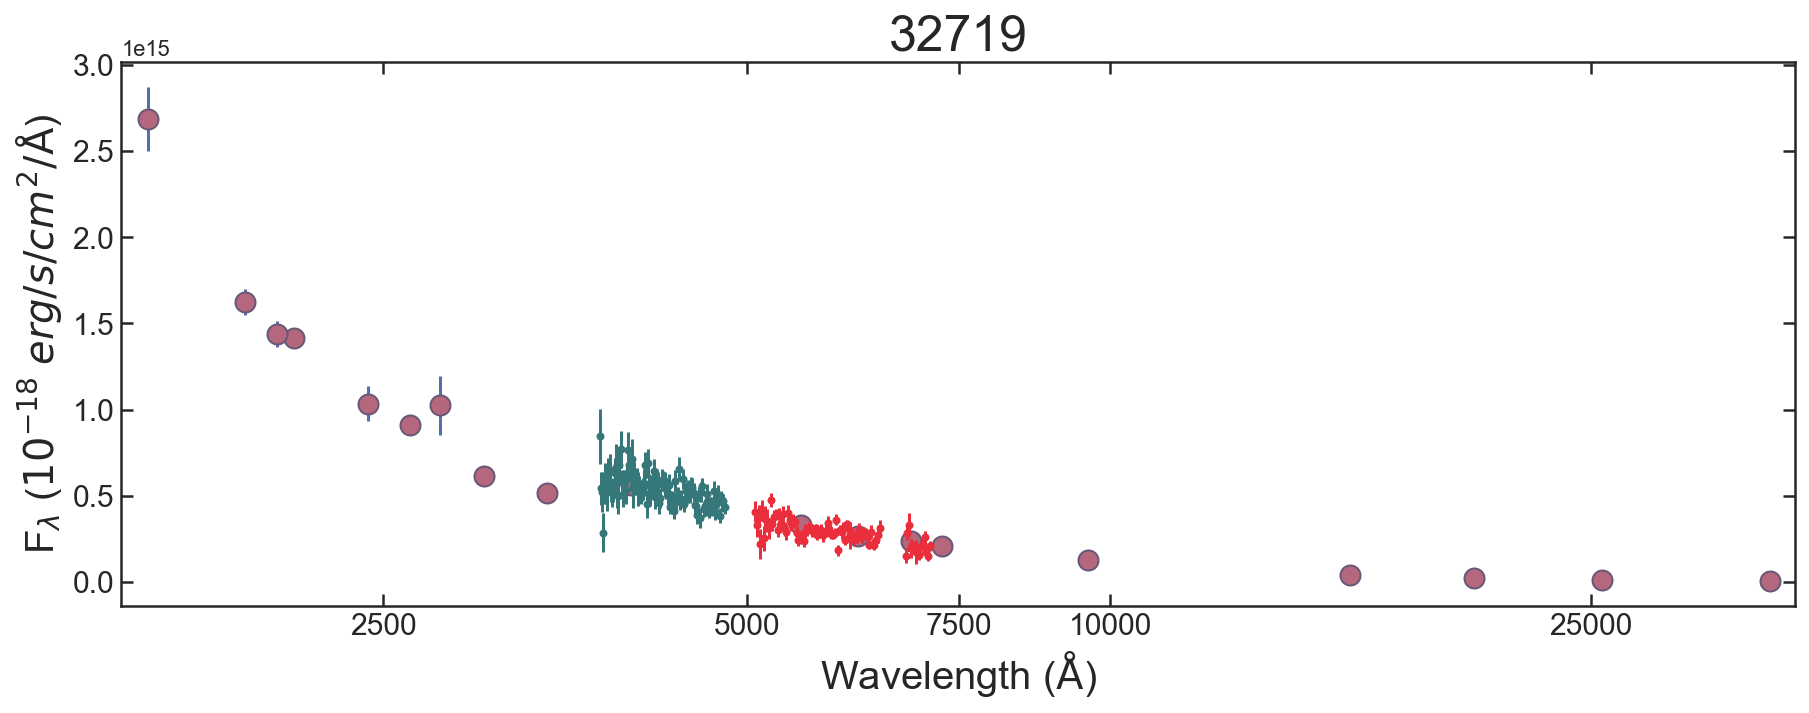

In [24]:
plt.figure(figsize=[15,5])
###############plot tab##################

plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
        linestyle='None', marker='o', markersize=3, color='#36787A', zorder = 2)

plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
        linestyle='None', marker='o', markersize=3, color='#EA2E3B', zorder = 2)

plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=10, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)
plt.xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))

plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
plt.title(galaxy, fontsize=25)
plt.xlabel(r'Wavelength ($\rm  \AA$)', fontsize=20)
plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.figure(figsize=[15,5])
###############plot tab##################

plt.errorbar(np.log10(Gs.Bwv_rf),Gs.SBfl *1E18,Gs.SBer *1E18,
        linestyle='None', marker='o', markersize=3, color='#36787A', zorder = 2)

plt.errorbar(np.log10(Gs.Rwv_rf),Gs.SRfl *1E18,Gs.SRer *1E18,
        linestyle='None', marker='o', markersize=3, color='#EA2E3B', zorder = 2)

plt.errorbar(np.log10(Gs.Pwv_rf),Gs.SPflx*1E18,Gs.SPerr*1E18,
        linestyle='None', marker='o', markersize=10, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)
plt.xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))

plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
plt.title(galaxy, fontsize=25)
plt.xlabel(r'Wavelength ($\rm  \AA$)', fontsize=20)
plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

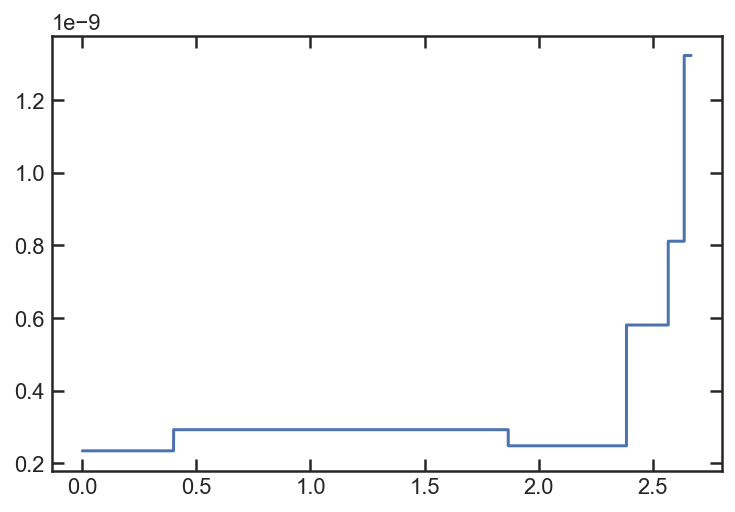

In [14]:
plt.plot(time,sfr)

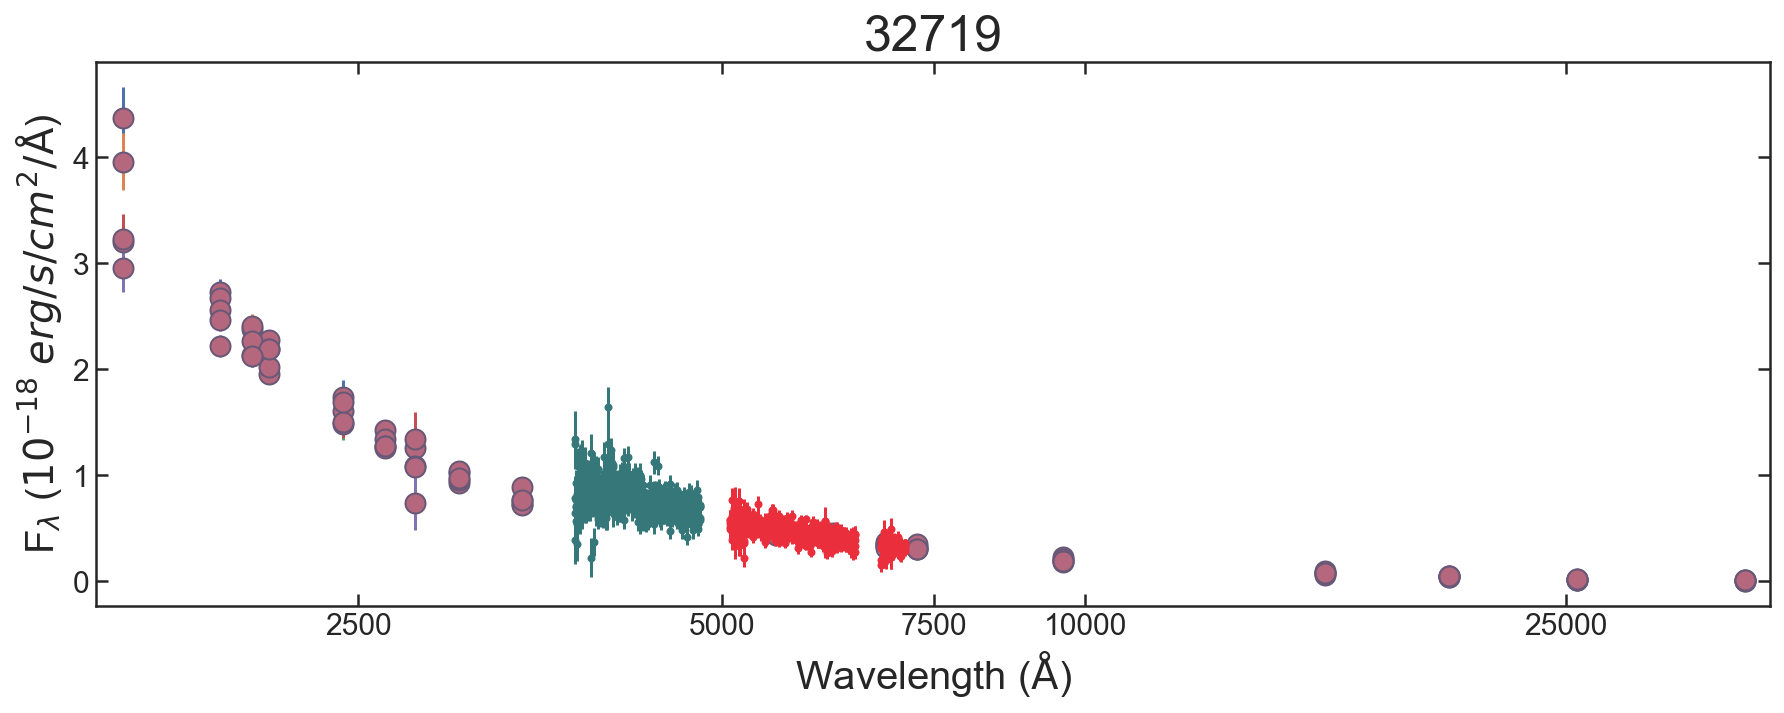

In [33]:
plt.figure(figsize=[15,5])
###############plot tab##################

Zs = [0.1,0.5,0.75,1,1.5]

for Z in Zs:

    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
    sp.params['dust1'] = 0

    sp.params['dust2'] = SF_db_p2.Av[3]
    # sp.params['logzsol'] = np.log10(SF_db_p2.Z[3])
    sp.params['logzsol'] = np.log10(Z)

    x,px = np.load('../Casey_data/posteriors/{0}_{1}_SFfit_p2_Pa.npy'.format(field, galaxy))
    a = x[px == max(px)][0]

    time, sfr, tmax = convert_sfh(get_agebins(a, binnum = 6), 
        [SF_db_p2.m1[3], SF_db_p2.m2[3], SF_db_p2.m3[3], SF_db_p2.m4[3], SF_db_p2.m5[3], SF_db_p2.m6[3]], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr) 

    wv,fl = sp.get_spectrum(tage=a,peraa=True)
    
    flam = F_lam_per_M(fl, wv * (1 + SF_db_p2.zgrism[3]), SF_db_p2.zgrism[3], 0, sp.stellar_mass)*10**SF_db_p2.lmass[3]
    
    Gs.Make_sim(wv,flam,SF_db_p2.zgrism[3],perturb = True , rndstate=np.random.randint(0,10000,1)[0])

    plt.errorbar(np.log10(Gs.Bwv_rf),Gs.SBfl *1E18,Gs.SBer *1E18,
            linestyle='None', marker='o', markersize=3, color='#36787A', zorder = 2)

    plt.errorbar(np.log10(Gs.Rwv_rf),Gs.SRfl *1E18,Gs.SRer *1E18,
            linestyle='None', marker='o', markersize=3, color='#EA2E3B', zorder = 2)

    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.SPflx*1E18,Gs.SPerr*1E18,
            linestyle='None', marker='o', markersize=10, markerfacecolor='#B5677D', zorder = 1,
                 markeredgecolor = '#685877',markeredgewidth = 1)
    plt.xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))

    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.title(galaxy, fontsize=25)
    plt.xlabel(r'Wavelength ($\rm  \AA$)', fontsize=20)
    plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

In [39]:
SF_db_p2.m1[3], SF_db_p2.m2[3], SF_db_p2.m3[3], SF_db_p2.m4[3], SF_db_p2.m5[3], SF_db_p2.m6[3]

(0.0396813813438505,
 0.056770525651530394,
 0.10622283653265521,
 0.12837145099039338,
 0.4283253309859349,
 0.09358802855753076)

In [ ]:
    field = sys.argv[1] 
    galaxy = int(sys.argv[2])
    specz = float(sys.argv[3])
    logmass = float(sys.argv[4])
    Av = float(sys.argv[5])
    Z = float(sys.argv[6])
    a = float(sys.argv[7])
    
    
GND 32917 1.25 9.726 0.28 0.5 2.67 0.04 0.057 0.106 0.128 0.428 0.094